In [1]:
!pip install datasets
import datasets
import torch
dataset = datasets.load_dataset("okite97/news-data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 14.7 MB/s 
     |████████████████████████████████| 115 kB 66.6 MB/s 
     |████████████████████████████████| 212 kB 69.2 MB/s 
     |████████████████████████████████| 163 kB 65.1 MB/s 
     |████████████████████████████████| 127 kB 57.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/okite97___csv/okite97--news-data-77215812580e30c7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
})

In [3]:
dataset['train'] #dataset de treino

Dataset({
    features: ['Title', 'Excerpt', 'Category'],
    num_rows: 4686
})

In [4]:
dataset['train']['Excerpt'][500]

"Nigeria's Aviation Ministry has said plans are in place to concession four of the country's airports which will enable private"

In [5]:
dataset['train']['Category'][500]

'business'

In [6]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english') #tokenizar as linhas

In [7]:
def split_tokens(row):
    row['tokens'] = tokenizer(row['Excerpt']) #tokeniza a linha com base nos tokens de basic_english
    return row

In [8]:
dataset = dataset.map(split_tokens) #aplica a função em todas as linhas o dataset

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens'],
        num_rows: 828
    })
})

In [10]:
dataset['train']['tokens'][500]

['nigeria',
 "'",
 's',
 'aviation',
 'ministry',
 'has',
 'said',
 'plans',
 'are',
 'in',
 'place',
 'to',
 'concession',
 'four',
 'of',
 'the',
 'country',
 "'",
 's',
 'airports',
 'which',
 'will',
 'enable',
 'private']

In [11]:
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(dataset['train']['tokens'], max_tokens=10000,
                                  specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [12]:
#print(vocab(dataset['train']['tokens'][500]))

In [13]:
def token2id(row):
    row['tokens_id'] = vocab(row['tokens'])
    return row

In [14]:
dataset = dataset.map(token2id)

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id'],
        num_rows: 828
    })
})

In [16]:
print(dataset['train']['tokens_id'][500])

[17, 14, 15, 394, 753, 7, 29, 159, 59, 6, 624, 4, 7299, 250, 3, 1, 62, 14, 15, 2609, 116, 28, 3489, 627]


In [17]:
print(set(dataset['train']['Category']))

{'tech', 'health', 'politics', 'entertainment', 'sports', 'business'}


In [18]:
def o_h_e(row):
  if(row['Category'] == 'tech'):
    row['new_category'] = [1,0,0,0,0,0]

  elif(row['Category'] == 'health'):
    row['new_category'] = [0,1,0,0,0,0]

  elif(row['Category'] == 'politics'):
    row['new_category'] = [0,0,1,0,0,0]

  elif(row['Category'] == 'entertainment'):
    row['new_category'] = [0,0,0,1,0,0]

  elif(row['Category'] == 'sports'):
    row['new_category'] = [0,0,0,0,1,0]
    
  else:
    row['new_category'] = [0,0,0,0,0,1]

  return row

In [19]:
dataset = dataset.map(o_h_e)

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id', 'new_category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id', 'new_category'],
        num_rows: 828
    })
})

In [21]:
print(dataset['train']['new_category'][500])

[0, 0, 0, 0, 0, 1]


In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
class OKITEDataset(Dataset):
  def __init__(self, dataset, vocab_size):
    self.dataset = dataset
    self.vocab_size = vocab_size
    self.data = dataset['tokens_id']

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    result = torch.zeros(self.vocab_size)
    return result.index_fill(0, torch.tensor(self.data[idx]), 1), torch.tensor(self.dataset['new_category'][idx], dtype=torch.float32)

In [24]:
BATCH_SIZE = 66
dataloader = DataLoader(OKITEDataset(dataset['train'], len(vocab)),
                        batch_size=BATCH_SIZE, shuffle=True)

In [25]:
for X, y in dataloader:
    print('X shape: ', X.shape)
    print('y shape: ', y.shape, y.dtype)
    break

X shape:  torch.Size([66, 10000])
y shape:  torch.Size([66, 6]) torch.float32


In [26]:
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self, vocab_size):
    super(TextClassifier, self).__init__()

    self.linear_stack = nn.Sequential(
        nn.Linear(vocab_size, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 6),
        nn.Softmax()
    )

  def forward(self, input):
    return self.linear_stack(input)

In [27]:
model = TextClassifier(len(vocab))

In [28]:
device = torch.device('cuda')
model.to(device)

TextClassifier(
  (linear_stack): Sequential(
    (0): Linear(in_features=10000, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=6, bias=True)
    (5): Softmax(dim=None)
  )
)

In [29]:
LR = 3e-2
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()  # loss function para problemas com duas classes
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [30]:
from tqdm import tqdm

progress_bar = tqdm(range(EPOCHS*len(dataloader)))

running_loss = []
for epoch in range(EPOCHS):

  epoch_loss = 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    y = torch.argmax(y,dim=1)#transforma y em int

    #optimizer.zero_grad()
    
    out = model(X)

    loss = loss_fn(out,y)
    epoch_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    progress_bar.update(1)

  epoch_loss = epoch_loss / len(dataloader)
  running_loss.append(epoch_loss)
  print('epoch loss:', epoch_loss)

  0%|          | 0/710 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 10%|█         | 71/710 [01:34<13:16,  1.25s/it]

epoch loss: 1.4312599863804563


 20%|██        | 142/710 [03:09<15:12,  1.61s/it]

epoch loss: 1.3208872734660833


 30%|███       | 213/710 [04:59<12:11,  1.47s/it]

epoch loss: 1.2435959107439283


 40%|████      | 284/710 [07:01<14:02,  1.98s/it]

epoch loss: 1.228484528165468


 50%|█████     | 355/710 [08:58<09:24,  1.59s/it]

epoch loss: 1.2172063572306029


 60%|██████    | 426/710 [10:54<07:29,  1.58s/it]

epoch loss: 1.1981771311289828


 70%|███████   | 497/710 [12:48<05:43,  1.61s/it]

epoch loss: 1.1788398044210084


 80%|████████  | 568/710 [14:45<04:05,  1.73s/it]

epoch loss: 1.1596653797257115


 90%|█████████ | 639/710 [16:38<01:52,  1.58s/it]

epoch loss: 1.1556384798506616


100%|██████████| 710/710 [18:37<00:00,  1.49s/it]

epoch loss: 1.1590129640740408


In [31]:
running_loss

[1.4312599863804563,
 1.3208872734660833,
 1.2435959107439283,
 1.228484528165468,
 1.2172063572306029,
 1.1981771311289828,
 1.1788398044210084,
 1.1596653797257115,
 1.1556384798506616,
 1.1590129640740408]

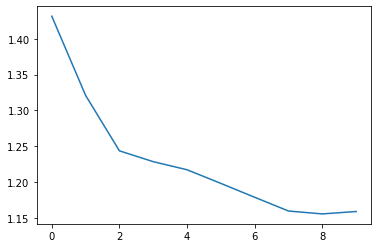

In [32]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [33]:
dataloader_test = DataLoader(OKITEDataset(dataset['test'], len(vocab)), batch_size=BATCH_SIZE, shuffle=True)

In [34]:
import numpy as np

correct = 0
total = 0

for X, y in dataloader_test:
  model.eval()
  X, y = X.to(device), y.to(device)
  y = torch.argmax(y, dim=1)

  out = model(X)
  out = torch.argmax(out, dim=1)

  correct += (out == y).sum().item()
  total += y.shape[0]

print(correct/total)

0.7789855072463768
